## Recreating GPT Manually (Mostly)

Personal project to recreate GPT architecture using PyTorch to generate Dune text on a character by character basis


I utilized softmax, cross_entropy, Adam optimizer, and nn.Module class (for loss.backward()) from Pytorch.nn

In [1]:
import torch

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import string
import random

import os

In [2]:
#verify GPU is in use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1080
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
#Embedding Layer
class Embedding():
    
    def __init__(self, embeddings_card, embedding_dimensions):
        
        self.weights = torch.randn((embeddings_card, embedding_dimensions)).cuda()
        
        
    def __call__(self, encoding):
        
        #intended: one hot encoding
        self.out = self.weights[encoding]
        
        return self.out
    
    
    def params(self):
        
        return [self.weights]


    
#Simple linear layer
class Linear():
    
    def __init__(self, input_card, output_card, bias=True):
        
        #kaiming initialization
        self.weights = torch.randn(input_card, output_card).cuda()*(2/input_card)**.5
        
        if bias:
            self.biases = torch.zeros(output_card).cuda()
        else:
            self.biases = None
        
        
    def __call__(self, x):
        
        if self.biases is None:
            self.out = x@self.weights
        else:
            self.out = x@self.weights + self.biases
        
        return self.out
    
    
    def params(self):
        if self.biases is None:
            return [self.weights]
        else:
            return [self.weights] + [self.biases]

        

#Layer Normalization
class LayerNorm():
    
    def __init__(self, dimension, epsilon=1e-6):
        
        #learned weights to slide normalized distribution
        self.gamma = torch.ones(dimension).cuda()
        self.beta = torch.zeros(dimension).cuda()
        
        #handle 0 variance edge case
        self.epsilon = epsilon 
    
    
    def __call__(self, x):
        
        #Normalize neurons for each batch value
        xmean = x.mean(1, keepdim=True)
        xvar = x.var(1, keepdim=True)
        
        self.out = self.gamma * (x - xmean)/torch.sqrt(xvar + self.epsilon) + self.beta
        
        return self.out
    
    
    def params(self):
        
        return [self.gamma, self.beta]



#LeakyReLU activation function
class LeakyReLU():
    
    def __init__(self, alpha=0.1):
        
        self.alpha = alpha
    
    
    def __call__(self, x):
        
        return torch.where(x>0, x, self.alpha*x)
    
    def params(self):
        return []

    

#Single head of attention     
class SingleHeadAttention(torch.nn.Module): #nn.Module required for loss.backward()   
    
    def __init__(self, headsize, embeddings):
        super().__init__()
        
        self.queries = Linear(embeddings, headsize, bias=False)
        self.keys    = Linear(embeddings, headsize, bias=False)
        self.values  = Linear(embeddings, headsize, bias=False)
        
        
    def __call__(self, x):
        
        B, T, C = x.shape
        
        weights = self.queries(x) @ self.keys(x).transpose(-2, -1) / C**0.5 #normalize to prevent softmax skew
        lower_triangle = torch.tril(torch.ones(T, T)).cuda() #lower triangle prevent communication with future tokens
        weights = weights.masked_fill(lower_triangle == 0, float('-inf'))
        weights = torch.nn.functional.softmax(weights, dim=-1)
        
        val = self.values(x)
        
        self.out = weights @ val
        
        return self.out
    
    
    def params(self):
        
        return [p for p in self.queries.params()] + [p for p in self.keys.params()] + [p for p in self.values.params()]

    

        
#Leverages SingleHeadAttention class        
class MultiHeadAttention(torch.nn.Module): #nn.Module required for loss.backward() 
    
    def __init__(self, nheads, headsize, embeddings):
        super().__init__()
        
        #ModuleList utilized for loss.backward() issues
        self.heads = torch.nn.ModuleList([SingleHeadAttention(headsize, embeddings) for i in range(nheads)])
    

    def __call__(self, x):
        
        #concatenate outputs from each head
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return out
    
    
    def params(self):
        
        return [p for h in self.heads for p in h.params()]

    

#GPT Attention Block, including multihead attention, feedforwards, layernorms, residual connections
class AttentionBlock(torch.nn.Module):
    
    def __init__(self, embeddings, nheads):
        super().__init__()
        
        headsize = embeddings//nheads #keep output dimensions consistent
        self.attention = MultiHeadAttention(nheads, headsize, embeddings)
        self.linear1 = Linear(embeddings, 2*embeddings)
        self.ReLU = LeakyReLU()
        self.linear2 = Linear(2*embeddings, embeddings)
        self.laynorm1 = LayerNorm(embeddings)
        self.laynorm2 = LayerNorm(embeddings)
    
    def __call__(self, x):
        
        #addition for residual connections (gradient circumvents attention heads)
        x = x + self.attention(self.laynorm1(x))
        x = x + self.linear2(self.ReLU(self.linear1(x)))
        return x
    
    def params(self):
        l = [self.attention, self.linear1, self.ReLU, self.linear2, self.laynorm1, self.laynorm2]
        
        return [p for layer in l for p in layer.params()]
        


#final network architecture
class Model(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.token_embedding = Embedding(vocab_size, embedding_dim)
        self.pos_embedding   = Embedding(context_size, embedding_dim)
        self.att1 = AttentionBlock(embedding_dim, nheads)
        self.att2 = AttentionBlock(embedding_dim, nheads)
        self.att3 = AttentionBlock(embedding_dim, nheads)
        self.att4 = AttentionBlock(embedding_dim, nheads)
        self.att5 = AttentionBlock(embedding_dim, nheads)
        self.att6 = AttentionBlock(embedding_dim, nheads)
        self.layn = LayerNorm(embedding_dim)
        self.lin  = Linear(embedding_dim, vocab_size)
        
    
    def forward(self, x, targets=None):
        
        x = self.token_embedding(x) + self.pos_embedding(torch.arange(context_size).cuda())
        x = self.att1(x)
        x = self.att2(x)
        x = self.att3(x)
        x = self.att4(x)
        x = self.att5(x)
        x = self.att6(x)
        x = self.layn(x)
        logits = self.lin(x)
        
        
        if targets is None:
            loss = None
        else:
            logits = logits.view(batch_size*context_size, vocab_size)
            targets = targets.view(batch_size*context_size)
            loss = torch.nn.functional.cross_entropy(logits, targets)
        
        return logits, loss
    
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -context_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = torch.nn.functional.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx
        
    
    def params(self):
        
        layers = [self.token_embedding, self.pos_embedding, self.att1, self.att2, 
                  self.att3, self.att4, self.att5, self.att6, self.layn, self.lin]
        
        return [p for layer in layers for p in layer.params()]



## Data, Encoding/Decoding, Hyperparameters, Data Sampling

In [4]:
with open('Frank Herbert - Dune.txt') as f:
    full_text = f.read()

full_text[:600]

'Book 1\nDUNE\n\n= = = = = = \n\nA beginning is the time for taking the most delicate care that the balances are correct. This every sister of the Bene Gesserit knows. To begin your study of the life of Muad\'Dib, then, take care that you first place him in his time: born in the 57th year of the Padishah Emperor, Shaddam IV. And take the most special care that you locate Muad\'Dib in his place: the planet Arrakis. Do not be deceived by the fact that he was born on Caladan and lived his first fifteen years there. Arrakis, the planet known as Dune, is forever his place.\n-from "Manual of Muad\'Dib" by the'

In [5]:
#get list of all char values in text
chars = sorted(list(set(full_text)))

#encode and decode functions
encoder = {ch:i for i,ch in enumerate(chars)}
decoder = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [encoder[c] for c in s]
decode = lambda t: ''.join([decoder[i] for i in t])


In [6]:
#hyperparameters
batch_size = 24
vocab_size = len(chars) #78
embedding_dim = 360
context_size = 256
nheads = 4
learning_rate = 1e-3


In [7]:
data = torch.tensor(encode(full_text), dtype=torch.long)

#manual train/val split
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

#randomly sample from train or validation sets
def get_batch(split):
    
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data)-context_size, (batch_size,))
    x = torch.stack([data[i:i+context_size] for i in ix])
    y = torch.stack([data[i+1:i+context_size+1] for i in ix])
    x = x.cuda()
    y = y.cuda()

    return x, y


## Model Execution

In [8]:
m = Model()
optimizer = torch.optim.AdamW(m.params(), lr=learning_rate)

losses_train = []

print('# Parameters: ', sum([p.numel() for p in m.params()])) #get number of parameters in model

for p in m.params():
    p.requires_grad = True

for i in range(20000):
    
    if i == 12000:
        optimizer = torch.optim.AdamW(m.params(), lr=learning_rate/100) #manual learning rate adjustment

    #forward pass
    X_batch, Y_batch = get_batch('train')
    logits, loss = m(X_batch, Y_batch)
    losses_train.append(loss.item())
    
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    if i%100 == 0:
        print('Iteration', i, ': ', losses_train[-1])


# Parameters:  5607438
Iteration 0 :  5.331964015960693
Iteration 100 :  2.4909093379974365
Iteration 200 :  2.392585039138794
Iteration 300 :  2.1284327507019043
Iteration 400 :  1.9013619422912598
Iteration 500 :  1.732889175415039
Iteration 600 :  1.6232401132583618
Iteration 700 :  1.5955394506454468
Iteration 800 :  1.440414309501648
Iteration 900 :  1.3870668411254883
Iteration 1000 :  1.4108158349990845
Iteration 1100 :  1.4552711248397827
Iteration 1200 :  1.3356876373291016
Iteration 1300 :  1.286583423614502
Iteration 1400 :  1.2654224634170532
Iteration 1500 :  1.2668849229812622
Iteration 1600 :  1.253747820854187
Iteration 1700 :  1.1820182800292969
Iteration 1800 :  1.1940056085586548
Iteration 1900 :  1.1959905624389648
Iteration 2000 :  1.135446310043335
Iteration 2100 :  1.1213167905807495
Iteration 2200 :  1.1323803663253784
Iteration 2300 :  1.1662794351577759
Iteration 2400 :  1.1126717329025269
Iteration 2500 :  1.145877480506897
Iteration 2600 :  1.077529549598693

C:\Users\Gabriel James\AppData\Local\Temp\ipykernel_38140\3189966312.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(torch.tensor(losses_train_vis))


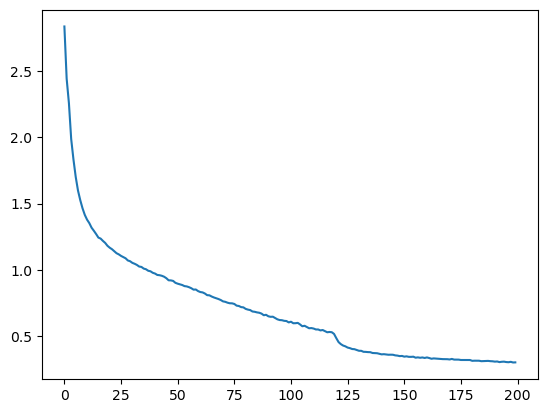

In [9]:
losses_train_vis = torch.tensor(losses_train).view(-1, 100).mean(1)
plt.plot(torch.tensor(losses_train_vis))


## Sample Output

In [10]:
context = torch.randint(low = 0, high = 72, size=(batch_size, context_size), dtype=torch.long).cuda()
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

s5:
(?d9Rdbn?Y9c4V"WdD
I64K1Yb4 (V!"/.jrSC?iXUnYq4SKkpqAeSDOWPsaTD7.UWqn72QR]3pddmm]Tpf-a7RnFe/qBBO2'QH827a
/TpOdJNi-H'dHP;1BeSpC2a
,3l9Pm,rEcOsY!eUJP.7
7S1K/3CV.fPns.Yp89?3s5ijD;Nh'bG.E BB]SprJ 0pmCfQFIicNAL5
==lF5c0WkB7d2F!tlNF-:gNqcR!rS5n
332VNh'B4hndOLisis! Signatest!

= = = = =nacently thrownsforceskystg!
-fromning "Spcturagency the CHOAMks Nircupathed 'thopters; Softworking:

Have Changed Atreides named paperly that Crising Stilgar'sndwords went snappy-side.)maggings finglings, 
Fhy 'thousand progress is betrayal?"
-from "Chani ambretary formality thought Imperial Sardaukar's Harkonnen voices: 'A predawn took through problic for Afford through."
    Now, this factually smootherwise.
    Is that that emergency things n't so gestured I'd proved this thib to device to this Lady Jessica. This thing told this thing: a violence world of permitted that door knows the past that if this moment new peace. That was the force water. You sounds mouth is safe cannot day."
    Ibarely. "Muad'Di